# About this Notebook

This notebook demonstrates how to analyze the treatment effect of the test messages using different methods, specifically:
- Basic analysis: calculate the average treatment effect (ATE) for all messages and demographic segments without any model.
- Linear regression: use a linear regression model to analyze the treatment effect.
- Causal Forest: use a causal forest model to analyze the treatment effect and visualize the treatment effect by demographic segments.

The data used in this notebook is generated from the `generate_data.py` script. The data is a simulated survey data of 9262 respondents with the following columns:
- `message_id`: the id of the message (0 if control, 1-5 if treated)
- `message_content`: the content of the message
- `age`
- `gender`
- `race`
- `education`
- `sexual_orientation`
- `party`
- `ideology`
- `income`
- `religion`
- `marital_status`
- `residential_area`
- `turnout_score`: a score from 0 to 100 indicating the likelihood of the respondent to vote in the upcoming election.
- `vote_choice`: the vote choice of the respondent (Harris, Trump, or Undecided)

**Note:** The data is generated with bias depending on the demographic. For example, someone identified as "Liberal" will have higher chance to vote for Harris.

# Install dependencies

In [1]:
%%capture
!pip install pandas numpy scipy scikit-learn lets-plot econml Faker itables


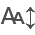

In [2]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=False)

# Generate and load data
Run the `generate_data.py` script to generate the data files. The script will create a folder named `data` in the current directory and save the data files there.
Here, we are just using the generated data files.


In [3]:
import numpy as np
import pandas as pd
from lets_plot import *
LetsPlot.setup_html()

In [4]:
df = pd.read_csv('data/survey_data.csv')
print(f'Preview of survey data')
df.sample(10)

Preview of survey data


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


# Data exploration
Check if there are inherent bias in the data. This is important to ensure that our "randomized" experiment is indeed randomized. We don't want the treatment group to be significantly different from the control group in terms of demographics. Otherwise, we cannot conclude that the treatment is effective or not in the basic analysis (i.e., not using model that accounts for heterogeneous treatment effect).

First, let's check the percentage of each demographic group

In [5]:
df_dem = df.copy()
df_dem['treated'] = (df['message_id'] > 0).astype(int)
df_dem['age_group'] = pd.cut(df_dem['age'], bins=[0, 29, 44, 64, 95], labels=['18-29', '30-44', '45-64', '65+']) # categorize age
df_dem_onehot = pd.get_dummies(df_dem[['treated', 'age_group', 'gender', 'race', 'education', 'sexual_orientation', 'party',
                                        'ideology', 'income', 'religion', 'marital_status', 'residential_area']], drop_first=True).astype(int)
df_dem_stats = df_dem_onehot.groupby('treated').mean().T.assign(diff = lambda x: x[1] - x[0]).sort_values('diff', ascending=False)
df_dem_stats = df_dem_stats.rename(columns={0: 'Control', 1: 'Treatment', 'diff': 'Difference'})

print('Percentage of respondents in each group:')
df_dem_stats.rename_axis("Group", axis=1)

Percentage of respondents in each group:


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


Now let's plot it

In [6]:
plt_df = df_dem_stats.reset_index()
ggplot(plt_df, aes(x='index', y='Difference')) + \
    geom_bar(stat='identity') + \
    labs(title='Demographic Bias in Treatment Group',
         x='Demographic Feature',
         y='Difference') + \
    theme(axis_text_x=element_text(angle=45, hjust=1)) +\
    ggsize(1200, 600)

There is no significant difference in absolute difference between the treatment and control groups. The largest difference is 0.025, which is not significant.
We can conclude that the treatment and control groups are similar in terms of demographics and can be considered randomized.

Let's further look at the distribution of the demographic features for each message.

In [7]:
plt_data = []
for message_id in np.sort(df['message_id'].unique()):
    if message_id > 0:
        plt_df = df_dem_onehot[(df_dem['message_id'] == message_id) | (df_dem['message_id'] == 0)].groupby('treated').mean().T.assign(diff = lambda x: x[1] - x[0]).sort_values('diff', ascending=False).reset_index()
        plt_df['message_id'] = f'message_{message_id}'
        plt_data.append(plt_df)
plt_data = pd.concat(plt_data, ignore_index=True)
plt_data['index'] = pd.Categorical(plt_data['index'])

# plot with facet
ggplot(plt_data, aes(x='index', y='diff')) + \
    geom_bar(stat='identity') + \
    scale_y_continuous(breaks=[-0.04, -0.03, -0.02, -0.01, 0, 0.01, 0.02, 0.03, 0.04], limits=[-0.04, 0.04]) + \
    labs(title='Demographic Bias in Treatment Group for Each Message',
         x='Demographic Feature',
         y='Difference') + \
    facet_wrap('message_id', ncol=1) + \
    theme(axis_text_x=element_text(angle=45, hjust=1)) +\
    ggsize(1200, 1200)

Similar observations can be made for each message. The largest difference is 0.04, which is not significant.

Next, we will use PCA to visualize the demographic features in a 2D space.
Our goal is to see if the treatment and control groups are spread out evenly in the PCA space.

In [8]:
# PCA visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_dem_onehot)
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# Create a DataFrame with PCA results
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['treated'] = df_dem['treated'].replace({0: 'Control', 1: 'Treatment'})
pca_df['message_id'] = df_dem['message_id'].replace({0: 'Control', 1: 'Message 1', 2: 'Message 2', 3: 'Message 3', 4: 'Message 4', 5: 'Message 5'})
# Plot PCA results

pca_plot = ggplot(pca_df, aes(x='PC1', y='PC2', color='treated')) + \
    geom_point(alpha=0.3) + \
    facet_wrap('message_id', ncol=2) + \
    labs(title='PCA of Demographic Features',
         x='Principal Component 1',
         y='Principal Component 2') + \
    theme_light() + \
    scale_color_manual(values=['blue', 'red'])
pca_plot.show()

There are clearly three distinct groups in this dataset.
This doesn't mean that the treatment is not randomized.
It just means there are 3 big groups of respondents that have similar demographic features.

Here we care more about if the Treatment and Control groups are spread out evenly in the PCA space.
In the PCA plot, we can see that the Treatment and Control groups are spread out.

# Basic treatment effect analysis

Here we will use simple frequency analysis to calculate the average treatment effect for the messages

## For all messages

In [9]:
mean_control = df[df['message_id'] == 0]['vote_choice'].value_counts(normalize=True).get('Harris', 0)
mean_treated = df[df['message_id'] > 0]['vote_choice'].value_counts(normalize=True).get('Harris', 0)
ate_avg = mean_treated - mean_control
print(f'Overall average treatment effect: {ate_avg:.4f}')

Overall average treatment effect: 0.0456


## For each message

In [10]:
# Gather percentage vote_choice for each message
count_by_message = df.groupby('message_id')['vote_choice'].value_counts(normalize=True).unstack().rename_axis(None, axis=1).reset_index()
print(f'Percentage of respondents voting by message, note that message_id = 0 is the control')
count_by_message

Percentage of respondents voting by message, note that message_id = 0 is the control


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


In [11]:
# Calculate the ATE
ate_avg_by_message = count_by_message - count_by_message.iloc[0]
ate_avg_by_message = ate_avg_by_message[ate_avg_by_message.index > 0]
print('Overall average treatment effect for each message')
ate_avg_by_message

Overall average treatment effect for each message


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


We can see that the treatment effect is positive for all messages, but the magnitude of the effect varies. The largest effect is for message 3, which has an average treatment effect of 0.07. This means that the message increased the probability of voting for Harris by 7 percentage points.

## For different demographic segments
Here we further analyze the effects on different demographic segments. We will look at the following segments:

In [12]:
demographic_segments = [
    ('Young voters', df['age'] <= 34),
    ('Black voters', df['race'] == 'Black'),
    ('Hispanic voters', df['race'] == 'Hispanic'),
    ('Low turnout', df['turnout_score'] < 20),
    ('Moderates', df['ideology'] == 'Moderate'),
    ('All', np.ones(len(df), dtype=bool)) # use for overall and plotting later
]

df['treated'] = (df['message_id'] > 0).astype(int)

demographic_ate = [
    df[segment].groupby('treated')['vote_choice'].value_counts(normalize=True).reset_index().rename_axis(None, axis=1).pivot(index='vote_choice', columns='treated', values='proportion').assign(ATE =lambda x: x[1] - x[0], segment=segment_name).reset_index()
    for segment_name, segment in demographic_segments
]

demographic_ate = pd.concat(demographic_ate, ignore_index=True)
demographic_ate = demographic_ate[demographic_ate['vote_choice'] == 'Harris'].drop('vote_choice', axis=1).rename(columns={0: 'control', 1: 'treated'})

print('Average treatment effect for each segment (all messages)')
demographic_ate[['segment', 'control', 'treated', 'ATE']].sort_values('ATE', ascending=False).reset_index(drop=True)

Average treatment effect for each segment (all messages)


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


## For combination of demographic segments and messages

We care more about the effect of each message, so let's further break down the analysis by message

In [13]:
demographic_message_ate = [
    (segment_name, df[segment].groupby('message_id')['vote_choice'].value_counts(normalize=True).unstack().reset_index().rename_axis(None, axis=1))
    for segment_name, segment in demographic_segments
]
demographic_message_ate = [
    (segment_name, count_by_message - count_by_message.iloc[0])
    for segment_name, count_by_message in demographic_message_ate
]
demographic_message_ate = pd.concat([pd.DataFrame(count_by_message).assign(segment=segment_name).reset_index(drop=True) for segment_name, count_by_message in demographic_message_ate])
demographic_message_ate = demographic_message_ate[demographic_message_ate['message_id'] > 0].assign(message_id=lambda x: x['message_id'].astype(int))

# add counts for each group
dem_counts = pd.DataFrame([
    [segment_name, message_id, df[(df['message_id'] == message_id) & (segment)].shape[0]]
    for segment_name, segment in demographic_segments for message_id in np.sort(df['message_id'].unique())
], columns=['segment', 'message_id', 'count'])

demographic_message_ate = pd.merge(demographic_message_ate, dem_counts, on=['segment', 'message_id'], how='left').rename(columns={'count': 'count_treated'})
demographic_ate =  pd.merge(demographic_message_ate, dem_counts[dem_counts['message_id'] == 0].drop('message_id', axis=1).rename(columns={'count': 'count_control'}), on=['segment'], how='left')

print('Average treatment effect for each segment and each message')
demographic_message_ate[['segment', 'message_id', 'Harris', 'Trump', 'Undecided']]

Average treatment effect for each segment and each message


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


Here we see the same pattern as before for the overall treatment effect on voting for Harris where the treatment effect is positive for all messages.
However, we can see that there are some positive treatment effects for Trump as well in the Low turnout.
This means that there are smaller segments of the low turnout group that are more likely to vote for Trump after receiving the treatment.

Next, let's have a closer look at the treatment effect for Harris only

### For each demographic segment for Harris only

In [14]:
# for Harris only
demographic_ate_harris = demographic_message_ate[['segment', 'message_id', 'Harris']].pivot(index='segment', columns='message_id', values='Harris').add_prefix('message_').rename_axis(None, axis=1)
demographic_ate_harris['average'] = demographic_ate_harris.mean(axis=1)
demographic_ate_harris

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


In [15]:
# heatmap
from lets_plot import *
plt_df = demographic_message_ate[['segment', 'message_id', 'Harris']].assign(message_id=lambda x: 'message_' + x['message_id'].astype(str))
# average for each segment
plt_df_avg = plt_df.groupby('segment')['Harris'].mean().reset_index().assign(message_id='average')
plt_df = pd.concat([plt_df, plt_df_avg], ignore_index=True)

ggplot(plt_df, aes(x='message_id', y='segment', fill='Harris')) + \
    geom_tile() + \
    scale_fill_gradient(low='white', high='red', limits=[0, 0.13]) + \
    labs(title='Average Treatment Effect for Harris by Demographic Segment',
         x='Message ID',
         y='Demographic Segment') + \
    theme(axis_text_x=element_text(angle=45, hjust=1))

Here we see that message 3 is the most effective for all demographic segments.
The treatment effect is largest for the Moderate (ideology) group, i.e.,
when presenting the message to the Moderate group, they are more likely to switch their vote to Harris.

# Simple analysis using Linear Regression
In this section, we will use a simple linear regression model to analyze the treatment effect.

In [16]:
import statsmodels.api as sm

## Data preparation

In [17]:
# Clean the data and categorize age and turnout_score
df_clean = pd.DataFrame({
    'vote_harris': (df['vote_choice'] == 'Harris').astype(int),  # 1 if Harris, 0 if Trump or Undecided
    'treated': (df['message_id'] > 0).astype(int),  # 0 if control, 1-5 if treated
})

# convert message id to its own column
for message_id in np.sort(df['message_id'].unique()):
    if message_id > 0:
        df_clean[f'message_{message_id}'] = (df['message_id'] == message_id).astype(int)

# add age_group and turnout group
df_clean= pd.concat([df_clean, pd.get_dummies(pd.DataFrame({
    'age_group': pd.cut(df['age'].fillna(df['age'].median()), bins=[0, 29, 44, 64, 95], labels=['18-29', '30-44', '45-64', '65+']),
    'turnout_group': pd.cut(df['turnout_score'].fillna(df['turnout_score'].median()), bins=[0, 20, 40, 60, 80, 100], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
})).astype(int)], axis=1)

# convert category variables to dummy variables
cat_vars = ['gender', 'race', 'education', 'sexual_orientation', 'party',
            'ideology', 'income', 'religion', 'marital_status', 'residential_area']

for var in cat_vars:
    dummies = pd.get_dummies(df[var], prefix=var, drop_first=True).astype(int)
    df_clean = pd.concat([df_clean, dummies], axis=1)

df_clean.sample(10)

Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


### Overall average treatment effect
We will use Ordinary Least Square as our model

In [18]:
model_lr = sm.OLS.from_formula('vote_harris ~ treated', data=df_clean).fit()
model_lr.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.011,19.731,0.000,0.203,0.248
treated,0.0456,0.012,3.658,0.000,0.021,0.070


Nice. The model gives us the same result as the overall average treatment effect (coef here is the ATE).
It also gives us the p-value and confidence interval for the treatment effect.
With a threshold of 0.05, we can conclude that the treatment effect is significant.

### Average treatment effect for each message

In [19]:
message_ids = np.sort(df['message_id'].unique())
message_ids = message_ids[message_ids > 0]

model_lr_by_messages = [
    sm.OLS.from_formula(f'vote_harris ~ treated', data=df_clean[(df_clean[f'message_{message_id}'] == 1) | (df_clean['treated'] == 0)]).fit()
    for message_id in message_ids
]
model_lr_by_messages_summary = [
    model.summary2().tables[1].assign(message_id=message_id).loc["treated", :].to_frame().T
    for message_id, model in zip(message_ids, model_lr_by_messages)
]
model_lr_by_messages = pd.concat(model_lr_by_messages_summary, ignore_index=True)
model_lr_by_messages.rename(columns={'Coef.': 'ATE'}, inplace=True)

print('Average treatment effect for each message:')
model_lr_by_messages[['message_id', 'ATE', 'P>|t|']]


Average treatment effect for each message:


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


Here we got the same result as in the basic analysis above for the ATE.
With a significant threshold of 0.05, we can see that message 1,3,4,5 are significant.
For message 2, the treatment effect is not significant.
This message should not be used in the future.

### Average treatment effect for each demographic segment

In [20]:
model_lr_by_segments = [
    sm.OLS.from_formula(f'vote_harris ~ treated', data=df_clean[segment]).fit()
    for segment_name, segment in demographic_segments
]

model_lr_by_segments_summary = [
    model.summary2().tables[1].assign(segment=segment_name).loc["treated", :].to_frame().T
    for segment_name, model in zip(demographic_segments, model_lr_by_segments)
]

model_lr_by_segments_summary = pd.concat(model_lr_by_segments_summary, ignore_index=True)
model_lr_by_segments_summary.rename(columns={'Coef.': 'ATE'}, inplace=True)
model_lr_by_segments_summary['segment'] = [segment_name for segment_name, _ in demographic_segments]

print('Average treatment effect for each segment:')
model_lr_by_segments_summary[['segment', 'ATE', 'P>|t|']].sort_values('ATE', ascending=False)

Average treatment effect for each segment:


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


Again, we got the same result as in the basic analysis for the ATE.
The treatment effect is significant for all segments except for the Low turnout and Black voters group.
Note that this is for all the messages combined.
We still need to analyze the treatment effect for each message for each segment.

## Average treatment effect for each demographic segment and message

In [21]:
model_lr_by_segments_messages = [
    (segment_name, message_id, sm.OLS.from_formula(f'vote_harris ~ treated', data=df_clean[(segment) & ((df_clean[f'message_{message_id}'] == 1) | (df_clean['treated'] == 0))]).fit())
    for segment_name, segment in demographic_segments for message_id in message_ids
]

model_lr_by_segments_messages_summary = [
    model.summary2().tables[1].assign(segment=segment_name, message_id=message_id).loc["treated", :].to_frame().T
    for segment_name, message_id, model in model_lr_by_segments_messages
]

model_lr_by_segments_messages_summary = pd.concat(model_lr_by_segments_messages_summary, ignore_index=True)
model_lr_by_segments_messages_summary.rename(columns={'Coef.': 'ATE'}, inplace=True)

print('Average treatment effect for each segment and message:')
model_lr_by_segments_messages_summary[['segment', 'message_id', 'ATE', 'P>|t|']]

Average treatment effect for each segment and message:


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


We also got the same result as in the basic analysis for the ATE.
Now, let's visualize both the ATE and the p-value for each demographic segment and message.

In [22]:
plt_df = model_lr_by_segments_messages_summary[['segment', 'message_id', 'ATE', 'P>|t|']].assign(message_id=lambda x: 'message_' + x['message_id'].astype(str))
plt_df['-log10_Pval'] = -np.log10(plt_df['P>|t|'].values.astype(float))
plt_df['is_sig'] = (plt_df['P>|t|'] < 0.05).astype('category')

plt_ate = ggplot(plt_df, aes(x='message_id', y='segment', fill='ATE')) + \
    geom_tile() + \
    scale_fill_gradient2(low='blue', mid='white', high='red', limits=[-0.15, 0.15]) + \
    labs(title='Average Treatment Effect by Demographic Segment and Message',
         x='Message ID',
         y='Demographic Segment') + \
    theme(axis_text_x=element_text(angle=45, hjust=1))

plt_pval = ggplot(plt_df, aes(x='message_id', y='segment', fill='-log10_Pval')) + \
    geom_tile() + \
    scale_fill_gradient(low='white', high='blue', limits=[0, 5]) + \
    labs(title='-log10(P-value) by Demographic Segment and Message',
         x='Message ID',
         y='Demographic Segment') + \
    theme(axis_text_x=element_text(angle=45, hjust=1)) + \
    geom_point(aes(color='is_sig', shape='is_sig'), size=3)

gggrid([
    plt_ate, plt_pval
], ncol=2) + ggsize(1200, 400)


Now we have a better understanding and confidence in our analysis.
Message 3 is the most effective message. It is significant for 3/5 demographic segments.

# Heterogeneous treatment effect analysis
In this section, we will analyze the heterogeneous treatment effects using CausalForest.

In [23]:
from econml.grf import CausalForest
from lets_plot import *
LetsPlot.setup_html()

In [24]:
# prepare the data
X = df_clean.drop(columns=['vote_harris', 'treated']).values
T = df_clean['treated'].values
Y = df_clean['vote_harris'].values
X.shape, T.shape, Y.shape

((9262, 76), (9262,), (9262,))

In [25]:
# CausalForest for all messages
model_cf = CausalForest(
    n_estimators=100,
    max_depth=5,
    random_state=42,
)
model_cf.fit(X, T, Y)
pred_cf = model_cf.predict(X)

print(f'Overall ATE: {ate_avg}')
print(f'Causal Forest ATE: {pred_cf.mean()}')


Overall ATE: 0.04558235684615
Causal Forest ATE: 0.047952999634931714


Here we see that the ATE similar to overall ATE.
This indicates that there is no significant bias or heterogeneity in the treatment effect.
Let's further analyze the treatment effect for each message.

In [26]:
model_cf_by_messages = []
for message_id in message_ids:
    model_tmp = CausalForest(
        n_estimators=100,
        max_depth=5,
        random_state=42,
    )

    df_filtered = df_clean[(df_clean[f'message_{message_id}'] == 1) | (df_clean['treated'] == 0)]
    X_tmp = df_filtered.drop(columns=['vote_harris', 'treated']).values
    T_tmp = df_filtered['treated'].values
    Y_tmp = df_filtered['vote_harris'].values

    model_tmp.fit(X_tmp, T_tmp, Y_tmp)
    effect_tmp = model_tmp.predict(X_tmp)
    model_cf_by_messages.append((
        message_id,
        model_tmp,
        effect_tmp,
        df_filtered.index
    ))

pred_cf_by_messages = pd.concat([
    pd.DataFrame({'message_id': message_id, 'ATE': effect.flatten(), 'index': index}) for message_id, _, effect, index in model_cf_by_messages
], ignore_index=True)

df_cf_by_messages = pred_cf_by_messages.groupby(['message_id'])['ATE'].mean()
print('Causal Forest ATE for each messages:')
df_cf_by_messages

Causal Forest ATE for each messages:


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


The Causal Forest model gives us similar results as the linear regression model.

### Average effect by demographic groups

Here we do not need to fit the Causal forest for each demographic segment

In [27]:
df_cf_by_messages_segment = []
for message_id, _, effect, index in model_cf_by_messages:
    df_dem_model = df.iloc[index].reset_index(drop=True)
    demographic_segments = [
        ('Young voters', df_dem_model['age'] <= 34),
        ('Black voters', df_dem_model['race'] == 'Black'),
        ('Hispanic voters',df_dem_model['race'] == 'Hispanic'),
        ('Low turnout', df_dem_model['turnout_score'] < 20),
        ('Moderates', df_dem_model['ideology'] == 'Moderate'),
        ('All', np.ones(len(df_dem_model), dtype=bool)) # use for overall and plotting later
    ]

    for name, segment in demographic_segments:
        df_cf_by_messages_segment.append((
            name,
            message_id,
            effect[segment].mean()
        ))

df_cf_by_messages_segment = pd.DataFrame(df_cf_by_messages_segment, columns=['segment', 'message_id', 'ATE']).pivot(index='segment', columns='message_id', values='ATE')
print('Causal Forest ATE for each segment:')
df_cf_by_messages_segment

Causal Forest ATE for each segment:


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


Here the ATE for each demographic segment is much more stable than the linear regression model.
This is because the causal forest model is able to capture the heterogeneity in the treatment effect and adjust for it,
while the basic analysis and linear regression model assume a constant treatment effect across all groups.

### Feature importance
Let's check the feature importance and see what group of the demographic most contribute to voting decision.
Here we will use the global model for all messages

In [28]:
print("\nFeature importance from Causal Forest:")
feature_importances = model_cf.feature_importances_
feature_names = list(df_clean.drop(columns=['vote_harris', 'treated']).columns)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)
importance_df


Feature importance from Causal Forest:


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


It's clear that the most important features are party and ideology.
In other words, these features have the most impact on the treatment effect.
Just to make sure, let group them by variable name and do some further inspection

In [29]:
importance_df['Feature_group'] = importance_df['Feature'].str.split('_', expand=True)[0]
importance_df_group = importance_df.groupby('Feature_group')['Importance'].mean().to_frame().sort_values('Importance', ascending=False)

print('Important variables:')
importance_df_group

Important variables:


Loading ITables v2.4.0 from the init_notebook_mode cell... (need help?)


In [30]:
# let's plot them
ggplot(importance_df_group.reset_index(), aes(x='Feature_group', y='Importance')) + geom_bar(stat='identity')

Now it is clear that party and ideology are the two main features that have the biggest impact in the model.
Let's further visualize these two feature to see that group of voters who are more likely to switch their vote from one candidate to another.

## Visualize treatment effect by demographic groups
Let's visualize the treatment effect by these features.

In [31]:
df_pred = pd.DataFrame({
    'pred_cf': pred_cf.flatten(),
})
df_pred['party'] = pd.Categorical(df['party'], categories=['Strong Republican', 'Lean Republican', 'Moderate Republican', 'Independent', 'Moderate Democrat', 'Lean Democrat', 'Strong Democrat', 'Other', 'Prefer not to say', ], ordered=True)
df_pred['ideology'] = pd.Categorical(df['ideology'], categories=['Very conservative', 'Conservative', 'Slightly conservative', 'Moderate', 'Slightly liberal', 'Liberal', 'Very liberal', 'Prefer not to say'], ordered=True)

plt_party = ggplot(df_pred, aes(x='party', y='pred_cf')) + \
    geom_boxplot() + \
    labs(title='Causal Forest: Average Treatment Effect by Party',
         x='Party',
         y='Average Treatment Effect') + \
    theme(axis_text_x=element_text(angle=45, hjust=1))

plt_ideology = ggplot(df_pred, aes(x='ideology', y='pred_cf')) + \
    geom_boxplot() + \
    labs(title='Causal Forest: Average Treatment Effect by Ideology',
         x='Ideology',
         y='Average Treatment Effect') + \
    theme(axis_text_x=element_text(angle=45, hjust=1))

gggrid([
    plt_party, plt_ideology
], ncol=2) + ggsize(1200, 600)

Here, we can see that, for the party that people support, the treatment effect is highest for Moderate Democrats.
This can be interpreted as people who are moderate Democrats are more likely to switch their vote to Harris after receiving the treatment (i.e., the message).

For the ideology, the treatment effect is highest for the Liberal group.
This means that people who identify as Liberal are more likely to switch their vote to Harris after receiving the treatment.
Here, people who identify as Very Liberal has one of the lowest treatment effects.
It makes sense because they are already likely to vote for Harris even without the treatment.

Note that the data is simulated and bias is added to the data.


# Future analysis

In this notebook, we analyzed the average treatment effect of the messages using different methods including basic analysis, linear regression, and causal forest.
The ATE in these analysis gives us a good idea of the overall treatment effect, even for within demographic segments and subgroups.
However, these models do not account for the interaction between the demographic features and confounding within subgroups.
Another drawback of this analysis is that we needed to bin the continuous features into categorical features, which we arbitrarily defined.
When we have a large number of features, this can lead to a combinatorial explosion of the number of segments.

In the future, we can use more advanced methods to analyze the Conditional Average Treatment Effect (CATE) using machine learning models such as Doubly Robust Learner (DRLearner) or Double Machine Learning (DML). These methods support propensity score matching, which is especially useful when dealing with imbalanced demographics between treatment and control groups.
They can also help us adjust for the confounding and interaction between the demographic features and the treatment effect.

# End of notebook

